## Imports

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from amlbench.benchmark.interface import Benchmark, Method, FeatureSpace
from amlbench.benchmark.benchmark_engine import BenchmarkEngine
from amlbench.benchmark.experiment_reports import get_reports_df
from amlbench.benchmark.split_strategies import LastDaysOfMonthSplit, TimePivotSplit
from amlbench.benchmark.project_folders import create_paths
from amlbench.benchmark.metric import Metric, METRIC_R2, METRIC_CVRMSE
from amlbench.benchmark.results_plots import (
    display_all_plots,
    display_bar_plot,
    display_box_plots,
)
from amlbench.benchmark.method_space import method_space

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LarsCV
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
)
from pathlib import Path
import joblib
import pandas as pd
import numpy as np

# Fixing the random seed
np.random.seed(10)

In [4]:
import sys

sys.path.append("../")  # append parent dir to sys.path

In [5]:
import wind_constants as cst
import main

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
plt.rcParams.update(cst.params)
sns.set_style("white")

In [8]:
pd.set_option("max_colwidth", 1500)
pd.set_option("display.width", None)

In [9]:
data = joblib.load("../data/processed/processed_uncleaned.joblib")

## Models to benchmark

In [10]:
# In the method object, you can choose to input any model and split_strategy

methods = method_space(
    model=[
        LinearRegression(normalize=True),
        LassoCV(normalize=True),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        LarsCV(normalize=True),
        ExtraTreesRegressor(),
        GradientBoostingRegressor(),
    ],
    split_strategy=[TimePivotSplit(), TimePivotSplit(pivot_quantile=0.5),],
)

### Features and Target (for relative production)

In [11]:
feature_space = FeatureSpace(name="all", features=cst.FEATURES, methods=methods)
reduced = FeatureSpace(name="reduced", features=cst.FEATURES_REDUCED, methods=methods)
national_average = FeatureSpace(
    name="national", features=cst.FEATURES_GLOBAL, methods=methods
)
benchmark = Benchmark(feature_spaces=[feature_space, reduced], target=cst.TARGET,)

### Features and Target (for total production)

In [12]:
alt_features = FeatureSpace(
    name="alternative",
    features=cst.ALT_FEATURES,
    methods=Method(model=LinearRegression(normalize=True), name="lr"),
)
alt_benchmark = Benchmark(feature_spaces=alt_features, target=cst.ALT_TARGET)

## Creating the ProjectFolders instance

In [13]:
# This is used to store data, models and reports

project_folders = create_paths(
    data_path=Path("../data"),
    models_path=Path("../models"),
    reports_path=Path("../reports"),
)

In [14]:
R2 = METRIC_R2
R2.cross_validation = 5

# Implementing and fitting benchmark

In [15]:
my_bench = BenchmarkEngine(
    project_folders=project_folders,
    benchmarks=[benchmark, alt_benchmark],
    metrics=[R2, METRIC_CVRMSE],
)

In [16]:
# In order to fit the Benchmark on several cores, it is possible to input the keyword argument n_jobs (by default at 1, disabling any parallelization)

my_bench = my_bench.fit(data=data, n_jobs=4, show_progress_bar=True)

Experiments: 100%|██████████| 29/29 [06:33<00:00, 13.56s/it]


# Results

In [17]:
df = get_reports_df(experiments=my_bench.experiments)

In [18]:
df = df.drop(
    columns=[
        "List of features",
        "Pre-Split Transformation",
        "Post-Split Transformation",
        "Feature Selection",
    ]
)

In [19]:
df.sort_values("R² Test", ascending=False)

,Target,Train/Test split,Model,Features Relevance,R² Train,R² Test,R² Global(Train+Test),R² 5-folds Cross Validation,CVRMSE Train,CVRMSE Test,CVRMSE Global(Train+Test)
12,relative_production,Train before 2018-09-11 08:00:00+02:00 and test after.,GradientBoostingRegressor,No features relevance available for this model,0.89,0.89,0.89,"[0.85, 0.89, 0.86, 0.89, 0.89]",24.75,24.75,24.79
10,relative_production,Train before 2018-09-11 08:00:00+02:00 and test after.,ExtraTreesRegressor,No features relevance available for this model,1.00,0.89,0.97,"[0.86, 0.88, 0.86, 0.9, 0.89]",0.00,24.74,13.60
13,relative_production,Train before 2016-10-18 05:00:00+02:00 and test after.,GradientBoostingRegressor,No features relevance available for this model,0.90,0.88,0.89,"[0.85, 0.89, 0.86, 0.89, 0.89]",23.77,26.05,24.96
4,relative_production,Train before 2018-09-11 08:00:00+02:00 and test after.,RandomForestRegressor,"speed_28 : 0.67, speed_44 : 0.06, temperature : 0.05, speed_24 : 0.04, speed : 0.01, pressure : 0.01, gust : 0.01, speed_11 : 0.01, direction_27 : 0.01, speed_32 : 0.01, direction_32 : 0.01, speed_53 : 0.01, speed_75 : 0.01, speed_76 : 0.01, direction_76 : 0.01, direction_93 : 0.01, speed_94 : 0.01, direction_94 : 0.01, direction : 0.0, direction_11 : 0.0, direction_24 : 0.0, speed_27 : 0.0, direction_28 : 0.0, direction_44 : 0.0, speed_52 : 0.0, direction_52 : 0.0, direction_53 : 0.0, direction_75 : 0.0, speed_84 : 0.0, direction_84 : 0.0, speed_93 : 0.0, month : 0.0",0.98,0.88,0.95,"[0.85, 0.88, 0.86, 0.89, 0.88]",9.66,25.23,16.06
11,relative_production,Train before 2016-10-18 05:00:00+02:00 and test after.,ExtraTreesRegressor,No features relevance available for this model,1.00,0.88,0.94,"[0.86, 0.89, 0.87, 0.9, 0.89]",0.00,26.18,18.71
19,relative_production,Train before 2016-10-15 20:00:00+02:00 and test after.,RandomForestRegressor,"speed_28 : 0.68, speed_44 : 0.07, temperature : 0.05, speed_24 : 0.03, gust : 0.02, speed_32 : 0.02, speed_53 : 0.02, speed_76 : 0.02, speed_94 : 0.02, speed : 0.01, pressure : 0.01, speed_11 : 0.01, speed_75 : 0.01, direction_94 : 0.01",0.98,0.87,0.92,"[0.84, 0.87, 0.85, 0.88, 0.88]",10.09,27.92,21.14
27,relative_production,Train before 2016-10-15 20:00:00+02:00 and test after.,GradientBoostingRegressor,No features relevance available for this model,0.88,0.87,0.87,"[0.83, 0.87, 0.84, 0.88, 0.88]",25.79,27.68,26.77
5,relative_production,Train before 2016-10-18 05:00:00+02:00 and test after.,RandomForestRegressor,"speed_28 : 0.68, speed_44 : 0.06, temperature : 0.05, speed_24 : 0.03, speed_32 : 0.02, speed : 0.01, pressure : 0.01, gust : 0.01, speed_11 : 0.01, direction_27 : 0.01, direction_32 : 0.01, speed_53 : 0.01, speed_75 : 0.01, speed_76 : 0.01, direction_76 : 0.01, direction_93 : 0.01, speed_94 : 0.01, direction_94 : 0.01, month : 0.01, direction : 0.0, direction_11 : 0.0, direction_24 : 0.0, speed_27 : 0.0, direction_28 : 0.0, direction_44 : 0.0, speed_52 : 0.0, direction_52 : 0.0, direction_53 : 0.0, direction_75 : 0.0, speed_84 : 0.0, direction_84 : 0.0, speed_93 : 0.0",0.98,0.87,0.93,"[0.85, 0.88, 0.86, 0.89, 0.88]",9.62,26.90,20.37
26,relative_production,Train before 2018-09-08 17:00:00+02:00 and test after.,GradientBoostingRegressor,No features relevance available for this model,0.88,0.87,0.88,"[0.83, 0.87, 0.84, 0.88, 0.88]",26.51,26.34,26.50
25,relative_production,Train before 2016-10-15 20:00:00+02:00 and test after.,ExtraTreesRegressor,No features relevance available for this model,1.00,0.87,0.93,"[0.84, 0.88, 0.85, 0.88, 0.88]",0.00,27.42,19.57


# Display Results

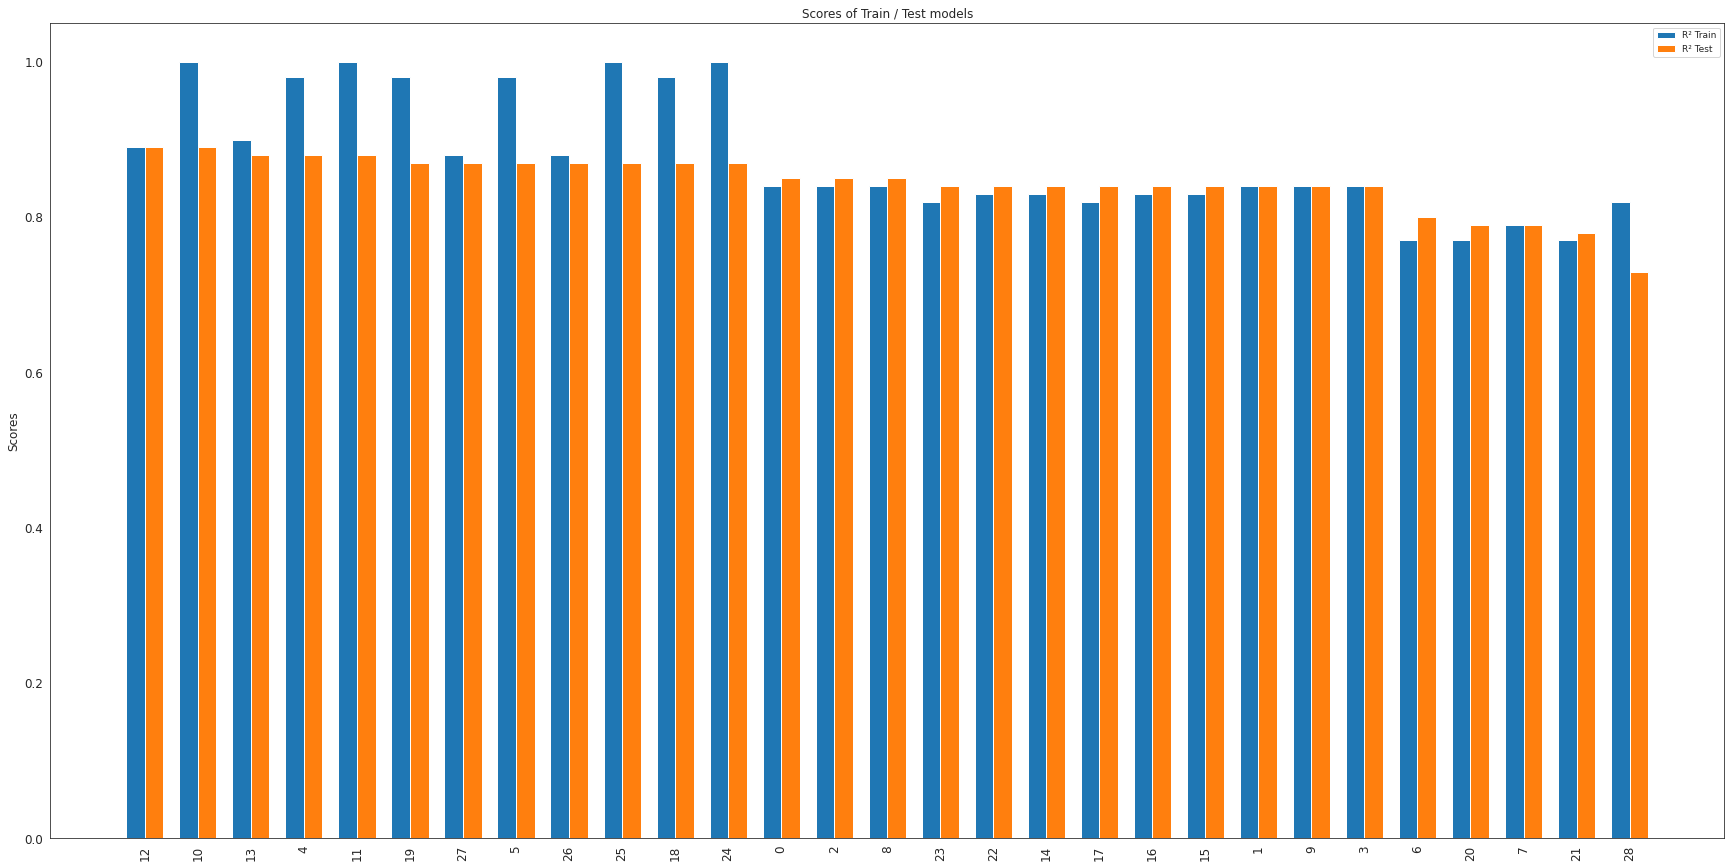

In [20]:
display_bar_plot(input_df=df)

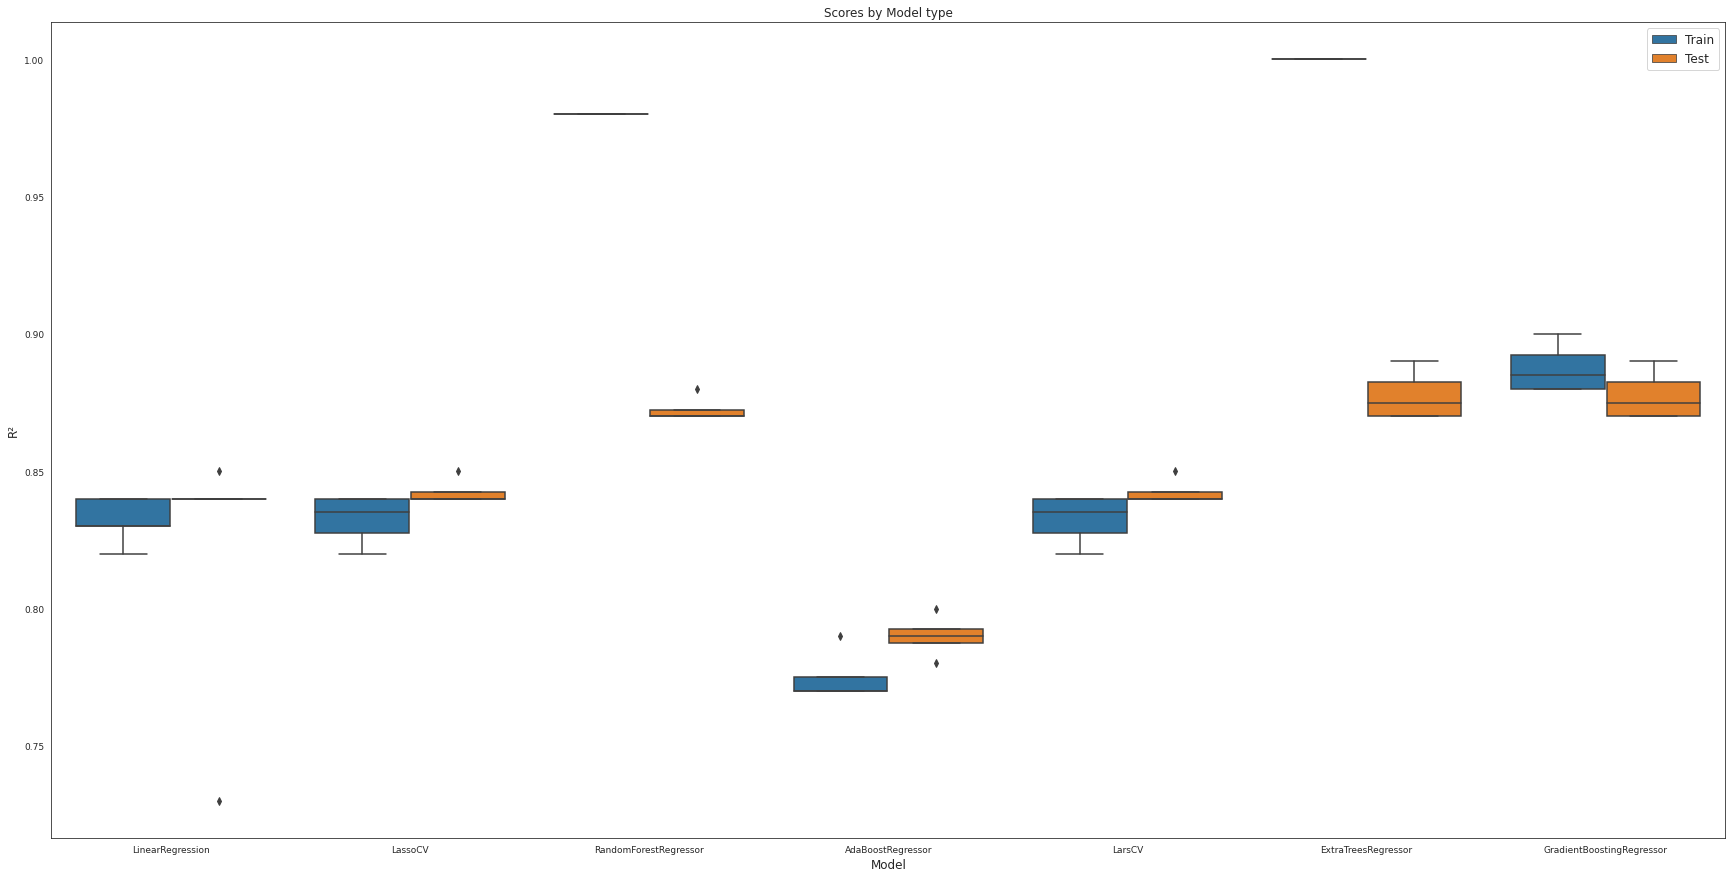

In [21]:
display_box_plots(input_df=df, method_attributes=["Model"])

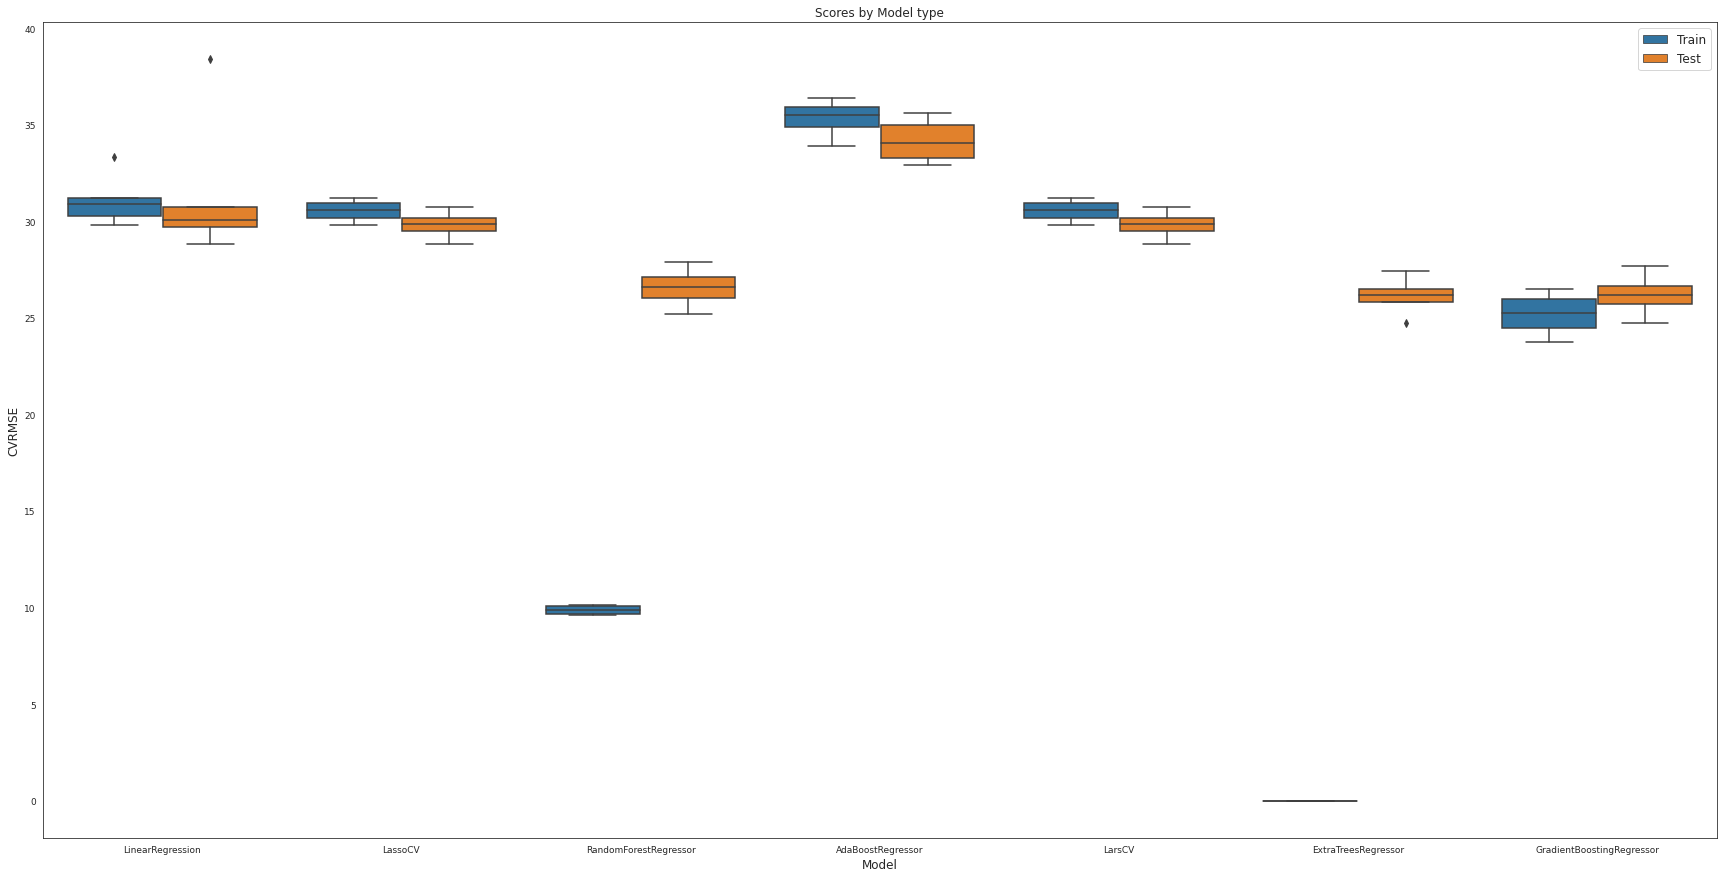

In [22]:
display_box_plots(input_df=df, metric_name="CVRMSE", method_attributes=["Model"])

Text(0, 0.5, 'Relative Production (MW/MW_installed)')

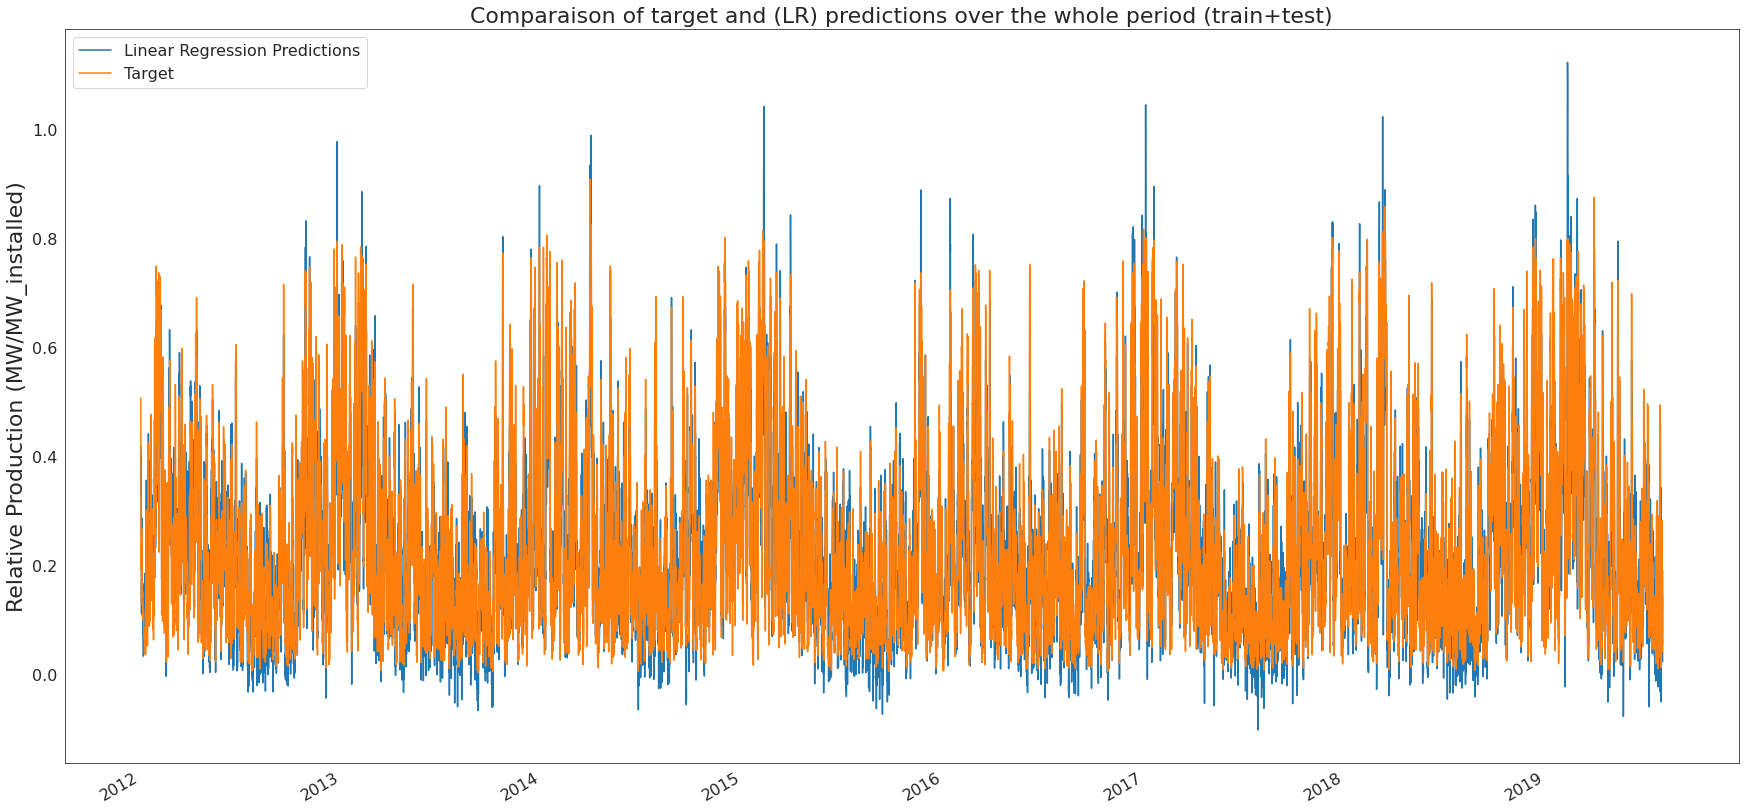

In [23]:
my_bench.experiments[0].predict(data[cst.FEATURES].dropna()).plot(
    label="Linear Regression Predictions"
)
data[cst.TARGET].plot(label="Target")
plt.legend()
plt.title(
    "Comparaison of target and (LR) predictions over the whole period (train+test)"
)
plt.ylabel("Relative Production (MW/MW_installed)")

Text(0, 0.5, 'Absolute Production (MWH)')

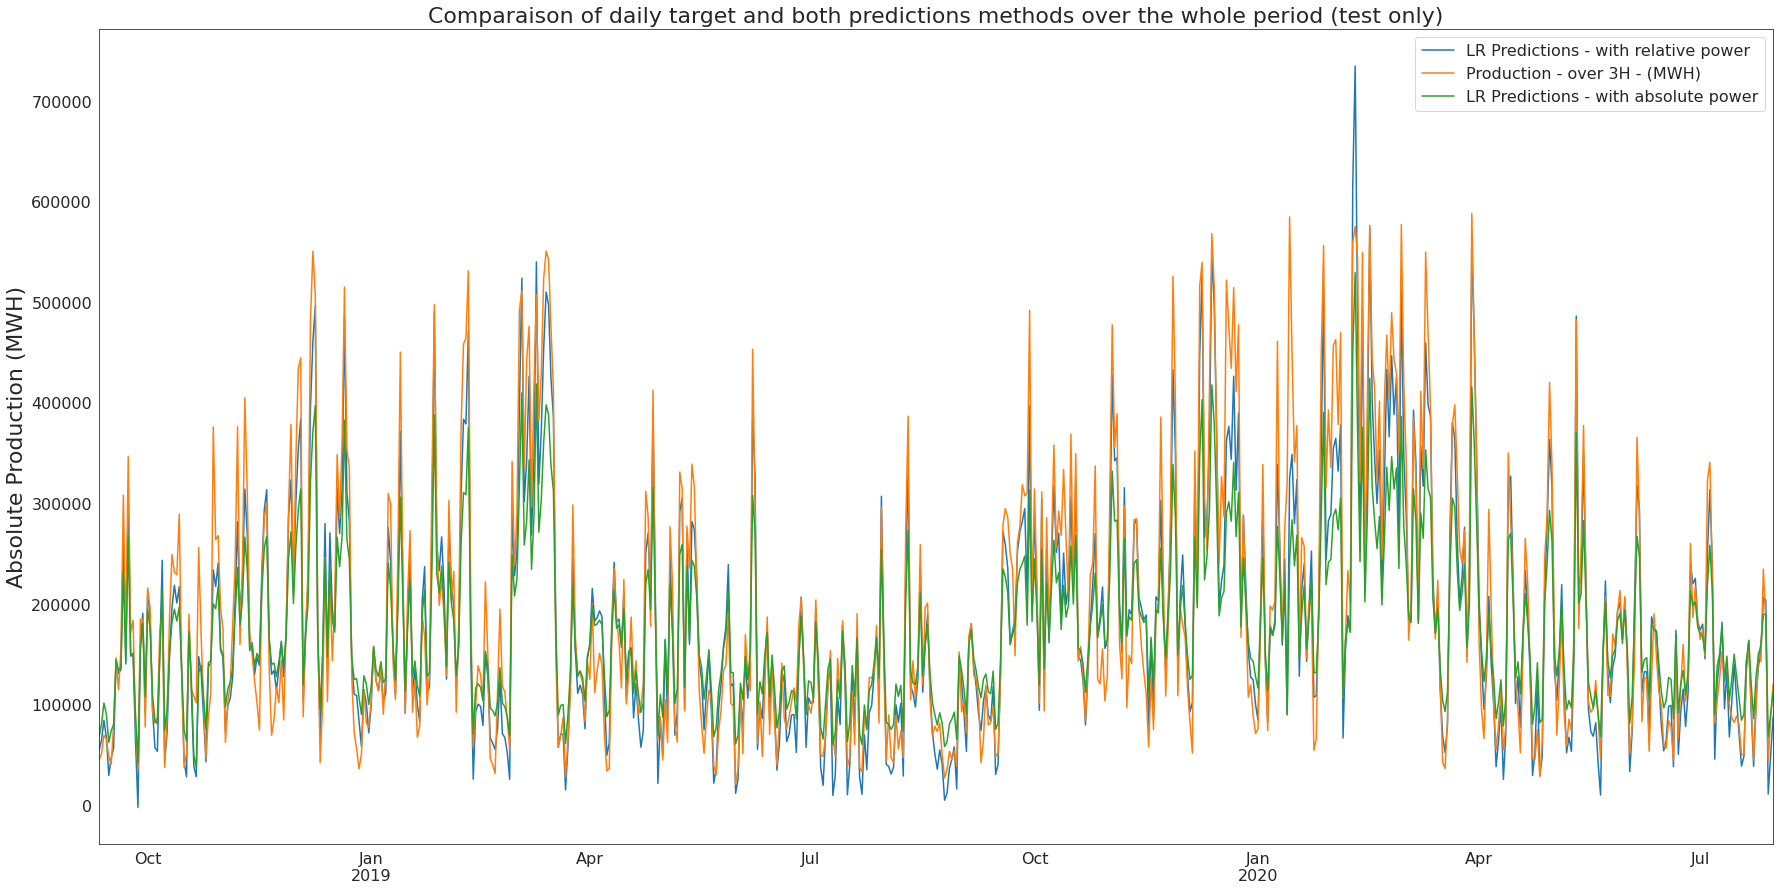

In [24]:
(
    my_bench.experiments[0].predict(data[cst.FEATURES].dropna()) * data["capacity"] * 6
).truncate(before="2018-09-11 08:00:00+02:00").resample("D").sum().plot(
    label="LR Predictions - with relative power"
)

data["production"].truncate(before="2018-09-11 08:00:00+02:00").resample(
    "D"
).sum().plot(label="Production - over 3H - (MWH)")

(my_bench.experiments[28].predict(data[cst.ALT_FEATURES].dropna())).truncate(
    before="2018-09-11 08:00:00+02:00"
).resample("D").sum().plot(label="LR Predictions - with absolute power")
plt.legend()
plt.title(
    "Comparaison of daily target and both predictions methods over the whole period (test only)"
)
plt.ylabel("Absolute Production (MWH)")

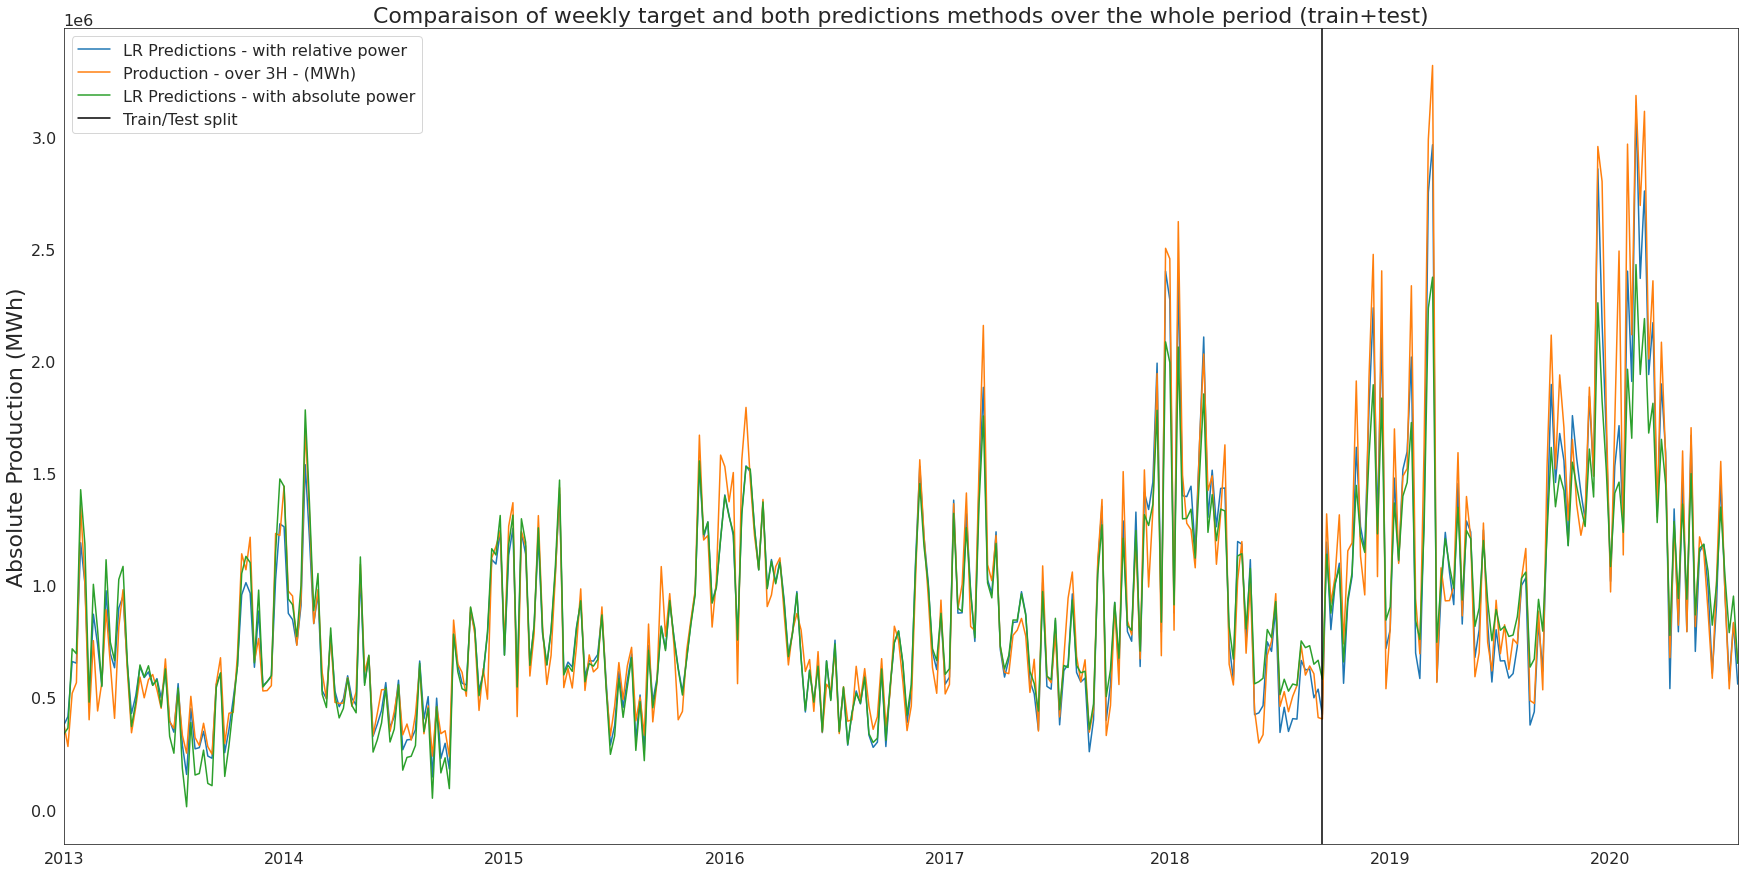

In [25]:
(
    my_bench.experiments[0].predict(data[cst.FEATURES].dropna()) * data["capacity"] * 6
).resample("W").sum().plot(label="LR Predictions - with relative power")
data["production"].resample("W").sum().plot(label="Production - over 3H - (MWh)")
(my_bench.experiments[28].predict(data[cst.ALT_FEATURES].dropna())).resample(
    "W"
).sum().plot(label="LR Predictions - with absolute power")
plt.title(
    "Comparaison of weekly target and both predictions methods over the whole period (train+test)"
)
plt.axvline("2018-09-11 08:00:00+02:00", c="black", label="Train/Test split")
plt.ylabel("Absolute Production (MWh)")
plt.legend()

In [26]:
pred = pd.DataFrame()

In [27]:
pred["model_prediction_LR"] = my_bench.experiments[0].predict(
    data[cst.FEATURES].dropna()
)

In [28]:
pred["model_prediction_extra_trees"] = my_bench.experiments[15].predict(
    data[cst.FEATURES].dropna()
)

In [29]:
pred["target"] = data[cst.TARGET].dropna()

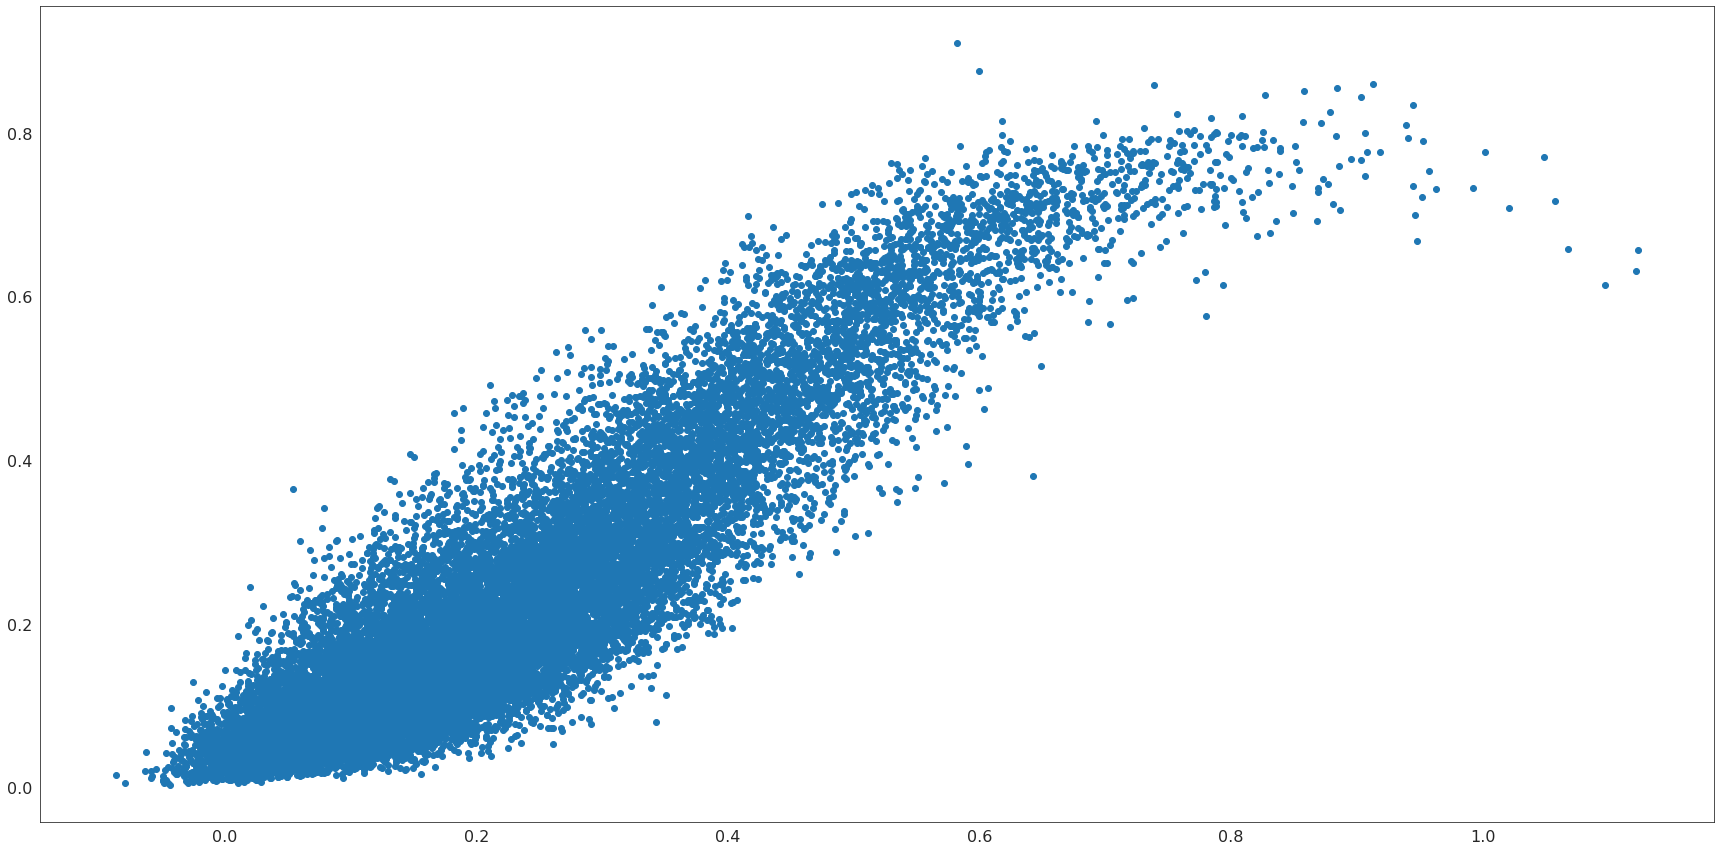

In [30]:
plt.scatter(pred["model_prediction_extra_trees"], pred["target"])

In [31]:
corr = data[cst.FEATURES + ["capacity"] + [cst.TARGET] + [cst.ALT_TARGET]].corr()

<AxesSubplot:>

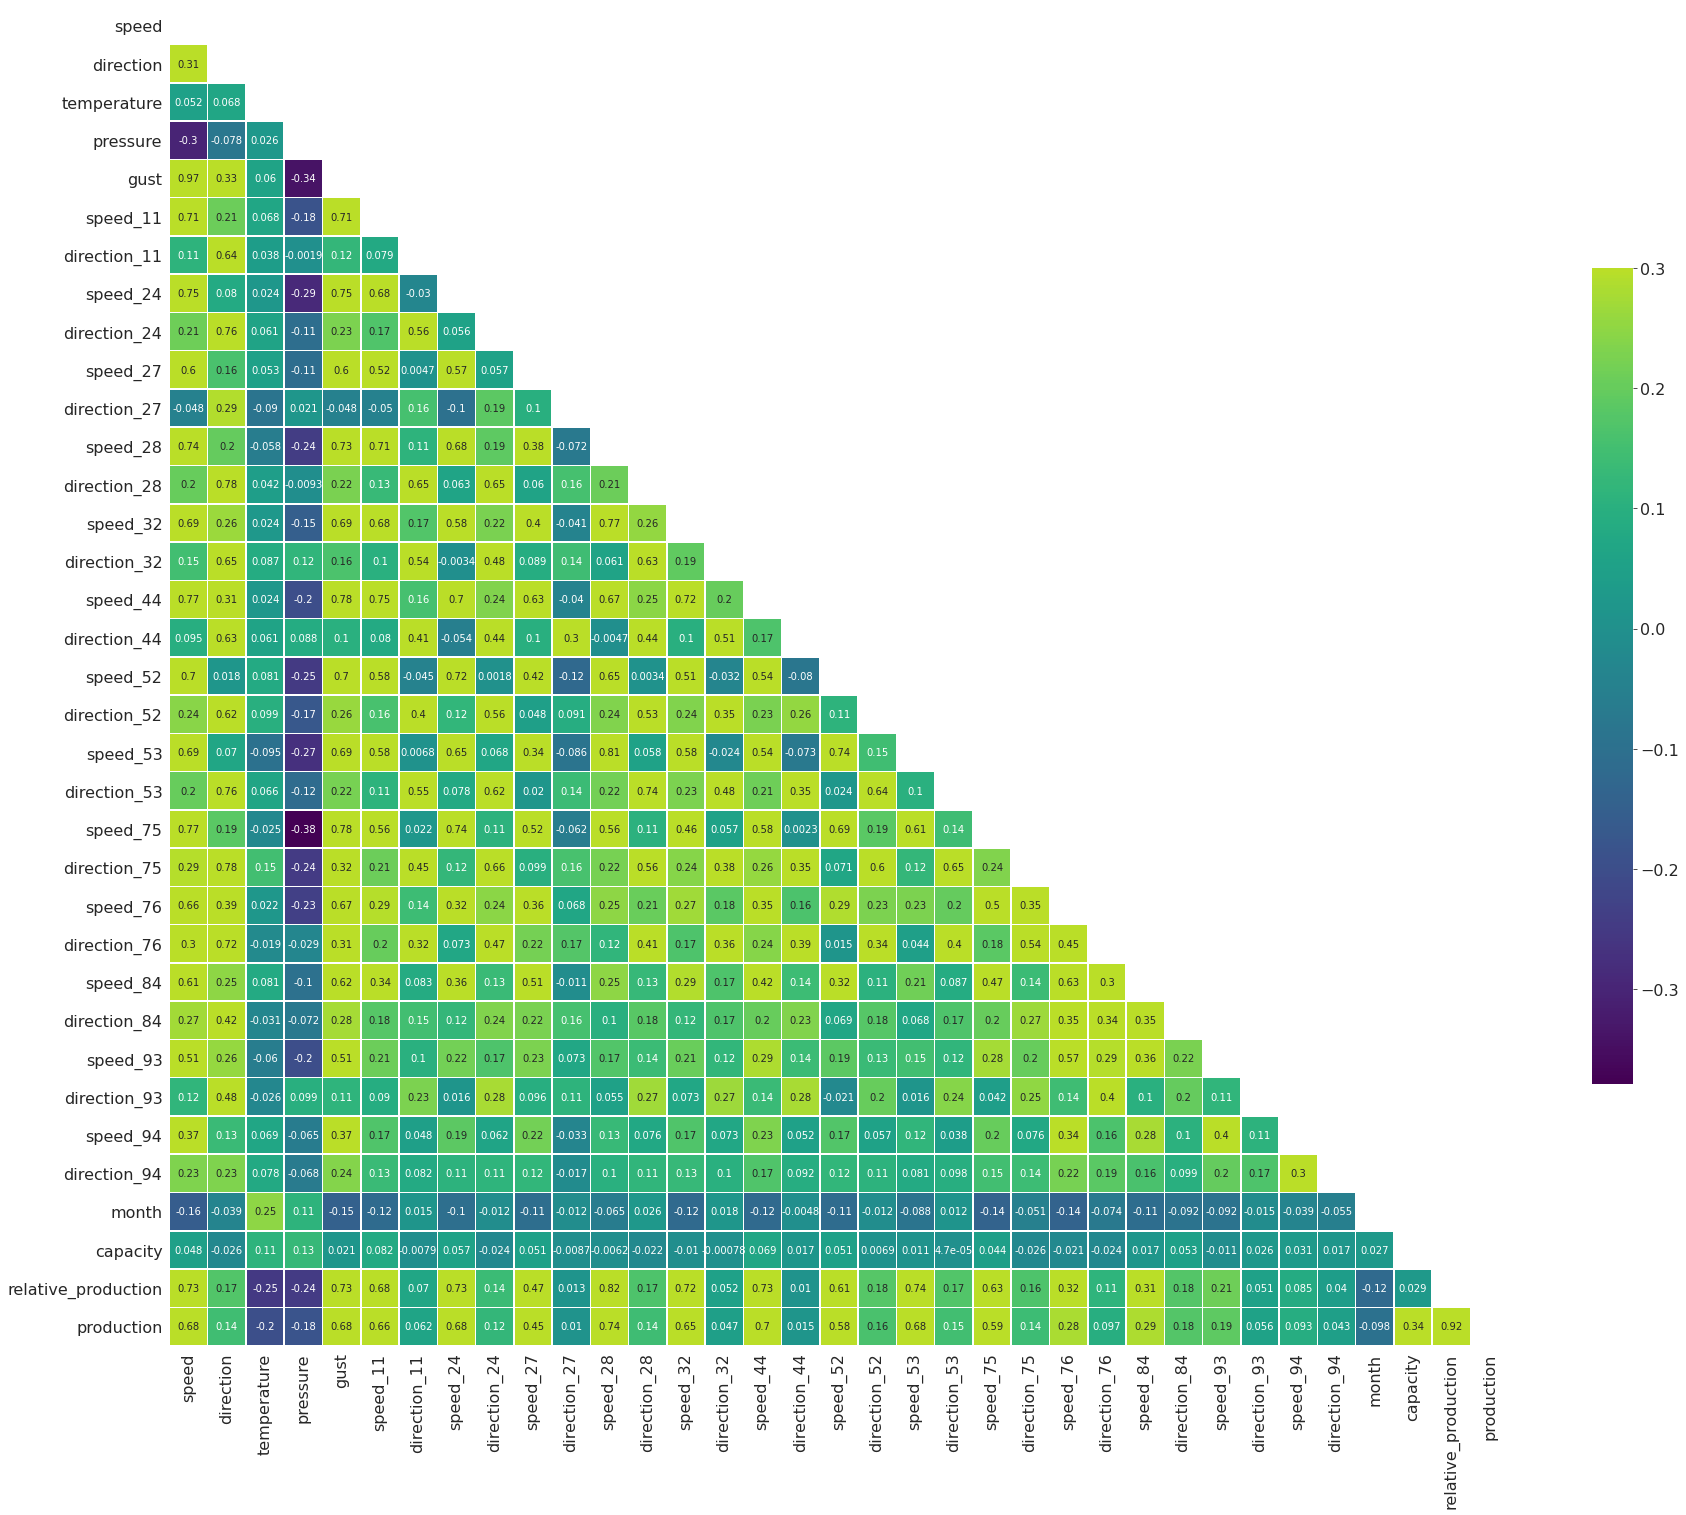

In [32]:
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    cmap="viridis",
)